## **[2024년 1학기 로봇공학] Ch. 4-a. Import a Robot**

- 작성자 : 서울시립대학교 전자전기컴퓨터공학부 박경훈 교수(gyunghoon.park@uos.ac.kr)
- 작성일 : 2024. 4. 23.

In [12]:
import spatialgeometry as sg
import spatialmath as sm
import roboticstoolbox as rtb
import numpy as np
from spatialmath.base import *
from math import *
from scipy import *
from roboticstoolbox.backends import swift
import matplotlib.animation as animation
import matplotlib.pyplot as plt

Ch. 4-a에서는 `Robotics Toolbox for Python`에서 제공하는 로봇 모델의 표현법들과, 저장된 로봇을 불러오는 방법에 대해 익혀보겠습니다.\
`Robotics Toolbox for Python`에서는 크게 다음의 3가지 형태의 로봇 표현법을 제공합니다.
- **Elementary transformation sequence (ETS)** : ${\rm Rot}$, ${\rm Trans}$ 등 기본적인 homogeneous transformation들의 조합을 통해 로봇의 기구학적 특성을 표현합니다. 
- **Universal robot description format (URDF)** : 잘 알려진 로봇 기술 방식인 URDF 파일에 적힌 정보들을 바탕으로 로봇 모델을 표현합니다.
- **Devanit-Hartenberg (DH)** : 역시 잘 알려진 DH convention으로 작성된 로봇 모델을 불러옵니다.

설명의 편의를 위해, 이번 파일에서는 공통적으로 Franka Emika Panda 로봇을 불러오는 법을 다루겠습니다.

### **Topic 1 : ETS Model**

`Robotics Toolbox for Python`에서 자체 제공하는 ETS model들은 다음과 같습니다.

In [2]:
rtb.models.list(type="ETS")

┌─────────────┬───────────────┬─────────────────────┬──────┬─────┬──────┬───────────┬──────────┬──────────┬──────────┐
│   class     │     name      │    manufacturer     │ type │ DoF │ dims │ structure │ dynamics │ geometry │ keywords │
├─────────────┼───────────────┼─────────────────────┼──────┼─────┼──────┼───────────┼──────────┼──────────┼──────────┤
│Panda        │ Panda         │ Franka Emika        │ ETS  │ 7   │ 3d   │ RRRRRRR   │          │          │          │
│Frankie      │ Frankie       │ Franka Emika, Omron │ ETS  │ 9   │ 3d   │ RPRRRRRRR │          │          │ mobile   │
│Puma560      │ Puma560       │ Unimation           │ ETS  │ 6   │ 3d   │ RRRRRR    │          │          │          │
│Planar_Y     │ Planar-Y      │                     │ ETS  │ 6   │ 3d   │ RRRRRR    │          │          │          │
│GenericSeven │ Generic Seven │ Jesse's Imagination │ ETS  │ 7   │ 3d   │ RRRRRRR   │          │          │          │
│XYPanda      │ XYPanda       │ Franka Emika    

이 중 저희는 table에서 가장 상단에 위치한 Panda를 불러오도록 하겠습니다.

In [3]:
panda_ETS = rtb.models.ETS.Panda()
print(panda_ETS)

ERobot: Panda (by Franka Emika), 7 joints (RRRRRRR)
┌─────┬───────┬───────┬────────┬─────────────────────────────────────────────┐
│link │ link  │ joint │ parent │             ETS: parent to link             │
├─────┼───────┼───────┼────────┼─────────────────────────────────────────────┤
│   0 │ link0 │     0 │ BASE   │ tz(0.333) ⊕ Rz(q0)                          │
│   1 │ link1 │     1 │ link0  │ Rx(-90°) ⊕ Rz(q1)                           │
│   2 │ link2 │     2 │ link1  │ Rx(90°) ⊕ tz(0.316) ⊕ Rz(q2)                │
│   3 │ link3 │     3 │ link2  │ tx(0.0825) ⊕ Rx(90°) ⊕ Rz(q3)               │
│   4 │ link4 │     4 │ link3  │ tx(-0.0825) ⊕ Rx(-90°) ⊕ tz(0.384) ⊕ Rz(q4) │
│   5 │ link5 │     5 │ link4  │ Rx(90°) ⊕ Rz(q5)                            │
│   6 │ link6 │     6 │ link5  │ tx(0.088) ⊕ Rx(90°) ⊕ tz(0.107) ⊕ Rz(q6)    │
│   7 │ @ee   │       │ link6  │ tz(0.103) ⊕ Rz(-45°)                        │
└─────┴───────┴───────┴────────┴─────────────────────────────────────────────┘


`print` 함수를 통해 ERobot 객체로 저장된 `panda_ETS`를 확인하실 수 있습니다.\
첫 번째 표에서 *ETS: Parent to link* 탭에 작성된 각각의 homogeneous transformation들은, tree 구조 상 현재의 parent link로부터 children link로 이동하기 위해 필요한 rotation과 translation 정보를 담고 있습니다.\
- `q0`, $\cdots$, `q6`는 joint angle 값이며, robot model 입장에서는 변수로 취급합니다.
- $\oplus$는 두 homogeneous transformation의 곱 연산을 의미합니다. 
- `tx`($\cdot$)는 ${\rm Trans}(\hat{x},\cdot)$를, `Rx`($\cdot$)는 ${\rm Rot}(\hat{x},\cdot)$ 등을 의미합니다.
- `qr`, `qz`는 미리 설정된 configuration vector들이며, 아래 방식으로 출력이 가능합니다.

In [4]:
print(panda_ETS.qr)

[ 0.         -0.3         0.         -2.2         0.          2.
  0.78539816]


`ERobot` 객체는 `ERobot.plot`() 함수를 이용하여 아래와 같이 그릴 수 있습니다.

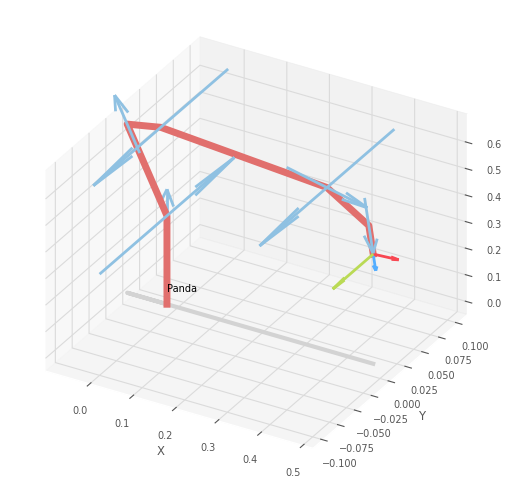

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Panda')

<Figure size 640x480 with 0 Axes>

In [5]:
panda_ETS.plot(panda_ETS.qr)

ERobot 모델은 `pyplot` 함수를 이용하여 애니매이션할 수도 있습니다.\
[sim_Panda_ETS.py](sim_Panda_ETS.py) 파일을 구동해보세요.

### **Topic 2 : URDF Model**

`Robotics Toolbox for Python`에서 제공하는 URDF 기반 모델들은 아래와 같습니다.

In [13]:
rtb.models.list(type="URDF")

┌────────────┬───────────────────────┬────────────────────┬──────┬─────┬──────┬────────────────────────────────────────────────────────────┬──────────┬──────────┬──────────┐
│   class    │         name          │    manufacturer    │ type │ DoF │ dims │                                                  structure │ dynamics │ geometry │ keywords │
├────────────┼───────────────────────┼────────────────────┼──────┼─────┼──────┼────────────────────────────────────────────────────────────┼──────────┼──────────┼──────────┤
│Panda       │ panda                 │ Franka Emika       │ URDF │ 7   │ 3d   │ RRRRRRR                                                    │          │ Y        │          │
│Frankie     │ frankie               │ Franka Emika       │ URDF │ 9   │ 3d   │ RPRRRRRRR                                                  │          │ Y        │          │
│FrankieOmni │ FrankieOmni           │ Custom             │ URDF │ 10  │ 3d   │ PPRRRRRRRR                                        

이 중에서 Panda를 아래와 같이 불러옵니다.\
기본적으로 URDF 모델은 `Swift`를 통해 시뮬레이션할 수 있으며, `plot` 함수를 사용하면 웹 브라우저에 새로운 창과 함께 시각화된 Panda를 확인할 수 있습니다.

In [14]:
panda_URDF = rtb.models.URDF.Panda()
panda_URDF.plot(panda_URDF.qr)

Retrieving file: C:/Users/user/AppData/Local/Programs/Python/Python312/Lib/site-packages/rtbdata/xacro/franka_description/meshes/visual/link0.dae
Retrieving file: C:/Users/user/AppData/Local/Programs/Python/Python312/Lib/site-packages/rtbdata/xacro/franka_description/meshes/visual/link1.dae
Retrieving file: C:/Users/user/AppData/Local/Programs/Python/Python312/Lib/site-packages/rtbdata/xacro/franka_description/meshes/visual/link2.dae
Retrieving file: C:/Users/user/AppData/Local/Programs/Python/Python312/Lib/site-packages/rtbdata/xacro/franka_description/meshes/visual/link3.dae
Retrieving file: C:/Users/user/AppData/Local/Programs/Python/Python312/Lib/site-packages/rtbdata/xacro/franka_description/meshes/visual/link4.dae
Retrieving file: C:/Users/user/AppData/Local/Programs/Python/Python312/Lib/site-packages/rtbdata/xacro/franka_description/meshes/visual/link5.dae
Retrieving file: C:/Users/user/AppData/Local/Programs/Python/Python312/Lib/site-packages/rtbdata/xacro/franka_description/me

Swift backend, t = 0.05, scene:
  panda

URDF 파일형으로 저장된 `panda_URDF` 파일의 세부 정보는 `print` 함수를 써서 확인 가능합니다.

In [15]:
print(panda_URDF)

ERobot: panda (by Franka Emika), 7 joints (RRRRRRR), 1 gripper, geometry, collision
┌─────┬──────────────┬───────┬─────────────┬────────────────────────────────────────────────┐
│link │     link     │ joint │   parent    │              ETS: parent to link               │
├─────┼──────────────┼───────┼─────────────┼────────────────────────────────────────────────┤
│   0 │ panda_link0  │       │ BASE        │ SE3()                                          │
│   1 │ panda_link1  │     0 │ panda_link0 │ SE3(0, 0, 0.333) ⊕ Rz(q0)                      │
│   2 │ panda_link2  │     1 │ panda_link1 │ SE3(-90°, -0°, 0°) ⊕ Rz(q1)                    │
│   3 │ panda_link3  │     2 │ panda_link2 │ SE3(0, -0.316, 0; 90°, -0°, 0°) ⊕ Rz(q2)       │
│   4 │ panda_link4  │     3 │ panda_link3 │ SE3(0.0825, 0, 0; 90°, -0°, 0°) ⊕ Rz(q3)       │
│   5 │ panda_link5  │     4 │ panda_link4 │ SE3(-0.0825, 0.384, 0; -90°, -0°, 0°) ⊕ Rz(q4) │
│   6 │ panda_link6  │     5 │ panda_link5 │ SE3(90°, -0°, 0°) ⊕ Rz(q5

URDF 파일의 문법에 대해서는 다른 파일에서 더욱 자세히 배우도록 합시다.

### **Topic 3 : DH Models**

마지막으로 DH convention을 이용하여 정의된 로봇 모델들에 대해 살펴보겠습니다.\
`Python Toolbox for Robotics`은 기본적으로 modified DH convention을 따르며, Toolbox에서 제공하는 DH 기반 모델들은 아래와 같습니다.

In [9]:
rtb.models.list(type="DH")

┌─────────┬───────────────┬────────────────────┬──────┬─────┬──────┬────────────┬──────────┬──────────┬──────────────────────────┐
│ class   │     name      │    manufacturer    │ type │ DoF │ dims │  structure │ dynamics │ geometry │         keywords         │
├─────────┼───────────────┼────────────────────┼──────┼─────┼──────┼────────────┼──────────┼──────────┼──────────────────────────┤
│Panda    │ Panda         │ Franka Emika       │ DH   │ 7   │ 3d   │ RRRRRRR    │ Y        │ Y        │                          │
│Puma560  │ Puma 560      │ Unimation          │ DH   │ 6   │ 3d   │ RRRRRR     │ Y        │ Y        │ dynamics, symbolic, mesh │
│Stanford │ Stanford arm  │ Victor Scheinman   │ DH   │ 6   │ 3d   │ RRPRRR     │ Y        │          │ dynamics                 │
│Ball     │ ball          │                    │ DH   │ 10  │ 3d   │ RRRRRRRRRR │ Y        │          │                          │
│Hyper    │ Hyper10       │                    │ DH   │ 10  │ 3d   │ RRRRRRRRRR │ Y

이 중에서 Panda를 아래와 같이 불러옵니다.

In [10]:
panda_DH = rtb.models.DH.Panda()
print(panda_DH)

DHRobot: Panda (by Franka Emika), 7 joints (RRRRRRR), dynamics, geometry, modified DH parameters
┌────────┬────────┬─────┬───────┬─────────┬────────┐
│ aⱼ₋₁   │  ⍺ⱼ₋₁  │ θⱼ  │  dⱼ   │   q⁻    │   q⁺   │
├────────┼────────┼─────┼───────┼─────────┼────────┤
│    0.0 │   0.0° │  q1 │ 0.333 │ -166.0° │ 166.0° │
│    0.0 │ -90.0° │  q2 │   0.0 │ -101.0° │ 101.0° │
│    0.0 │  90.0° │  q3 │ 0.316 │ -166.0° │ 166.0° │
│ 0.0825 │  90.0° │  q4 │   0.0 │ -176.0° │  -4.0° │
│-0.0825 │ -90.0° │  q5 │ 0.384 │ -166.0° │ 166.0° │
│    0.0 │  90.0° │  q6 │   0.0 │   -1.0° │ 215.0° │
│  0.088 │  90.0° │  q7 │ 0.107 │ -166.0° │ 166.0° │
└────────┴────────┴─────┴───────┴─────────┴────────┘

┌─────┬───────────────────────────────────────┐
│tool │ t = 0, 0, 0.1; rpy/xyz = -45°, 0°, 0° │
└─────┴───────────────────────────────────────┘

┌─────┬─────┬────────┬─────┬───────┬─────┬───────┬──────┐
│name │ q0  │ q1     │ q2  │ q3    │ q4  │ q5    │ q6   │
├─────┼─────┼────────┼─────┼───────┼─────┼───────┼──────┤


`print` 함수의 결과로 3개의 표가 출력되는데, 특히 1번째 표는 *DH parameters*를 정리해둔 표입니다.\
표의 변수들은 각각 아래를 의미합니다. 
- $\theta_j$ : Joint angle
- $d_j$ : Link offset
- $a_j$ : Link length
- $\alpha_j$ : Link twist
- $q^-$, $q^+$ : Joint angle의 하한값과 상한값

`plot` 함수를 사용하면 ETS 모델과 동일한 방식의 시각화 결과를 얻을 수 있습니다.

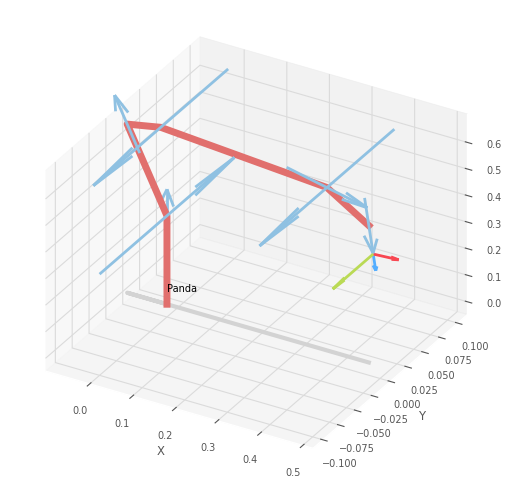

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Panda')

<Figure size 640x480 with 0 Axes>

In [11]:
panda_DH.plot(panda_DH.qr)